In [1]:
# fundamentals
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import partial_trace, DensityMatrix, state_fidelity, Statevector, random_statevector
from qiskit.circuit.library import U1Gate

# simulator
from qiskit_aer import Aer

# hardware
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService

# graphics
from qiskit.visualization import plot_bloch_multivector
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

# mathematics
import numpy as np
from scipy.stats import unitary_group

# miscellaneous
import time

In [2]:
## CONSTANTS
NUMBER_OF_BITS = 1
NUMBER_OF_QUBITS = 2 # you will always have two qubits, you will only add more unitary gates to correct for error
MAX_REGISTERS = 5 # number of registers that ceases the simulation

## STATES
zerozero = DensityMatrix.from_label('0') # creates |0><0|
oneone =  DensityMatrix.from_label('1') # creates |1><1|

In [3]:
## FUNCTIONS

# creates the entire dynamic circuit
def vmc_circuit(num_qubits, alpha, beta, register_number):
    vmc_circuit = QuantumCircuit(num_qubits, NUMBER_OF_BITS)
    
    # initialize states
    create_random_state(alpha, beta, register_number, vmc_circuit)
    create_plus(vmc_circuit)
    vmc_circuit.barrier()
    
    # add unitaries and CNOTs
    add_gates(vmc_circuit, register_number)

    # add measurement on |+> register
    # if result is |0>, then it is success
    # if result is |1>, thes it is failure and we have to correct the state
    vmc_circuit.measure(1, 0)

    return vmc_circuit


# creates the entire dynamic circuit with recycled state in case of failed measurement |1><1|
def vmc_circuit_recycled_state(num_qubits, alpha, beta, register_number):
    vmc_circuit = QuantumCircuit(num_qubits, NUMBER_OF_BITS)
    
    # initialize states
    create_random_state_recycled(alpha, beta, vmc_circuit)
    create_plus(vmc_circuit)
    vmc_circuit.barrier()
    
    # add unitaries and CNOTs
    add_gates(vmc_circuit, register_number)

    # add measurement on |+> register
    # if result is |0>, then it is success
    # if result is |1>, thes it is failure and we have to correct the state
    vmc_circuit.measure(1, 0)

    return vmc_circuit


# adds needed number of unitaries and CNOTs
def add_gates(quantum_circuit, register_number):
    number_of_gates_applied_on_register = 2**(register_number - 1) # calculates number of unitaries in register register_number
    for unitary in range(0, number_of_gates_applied_on_register):
         # applying required number of unitaries on the correct register
         quantum_circuit.p(phase, 1)
         # quantum_circuit.unitary(unitary_matrix, [1], label=r"$U_{\varphi}$")
    quantum_circuit.cx(0, 1)
    

# creates starting states |+> everywhere except for the first register
def create_plus(quantum_circuit):
    quantum_circuit.h(1)


# creates initial random qubit state
def create_random_state(alpha, beta, register_number, quantum_circuit):
    norm = np.sqrt(abs(alpha)**2 + abs(beta)**2) # normalization
    state = [alpha / norm, beta / norm]

    # add or initialize this state in circuit
    quantum_circuit.initialize(state, 0)
    
    # apply hermitian conjugate of unitary required number of times
    num_of_conjugated_unitaries_applied = 2**(register_number - 1) - 1
    for i in range(0, num_of_conjugated_unitaries_applied): # need to add error from previous measurements
        quantum_circuit.p(phase, 0).inverse()


# creates initial random qubit state from recycled state
def create_random_state_recycled(alpha, beta, quantum_circuit):
    norm = np.sqrt(abs(alpha)**2 + abs(beta)**2) # normalization
    state = [alpha / norm, beta / norm]

    # add or initialize this state in circuit
    quantum_circuit.initialize(state, 0)

In [4]:
## FUNCTIONS TO CREATE STATIC RESULTING CIRCUIT THAT WAS SUCCESSFUL IN THE END

# creates the entire static circuit
def vmc_circuit_static(register_number, alpha, beta):
    vmc_circuit = QuantumCircuit(register_number + 1, NUMBER_OF_BITS)
    
    # initialize states
    create_random_state_static(alpha, beta, vmc_circuit)
    create_plus_static(vmc_circuit)
    vmc_circuit.barrier()
    
    # add unitaries and CNOTs and measurements
    add_gates_static(vmc_circuit)

    return vmc_circuit


# # creates the entire static circuit from recycled state
# def vmc_circuit_static_recycled(register_number, recycled_state):
#     vmc_circuit = QuantumCircuit(register_number + 1, NUMBER_OF_BITS)
    
#     # initialize states
#     state = [recycled_state[0], recycled_state[1]]
#     vmc_circuit.initialize(state, 0)
#     create_plus_static(vmc_circuit)
#     vmc_circuit.barrier()
    
#     # add unitaries and CNOTs and measurements
#     add_gates_static(vmc_circuit)

#     return vmc_circuit


# adds unitaries, CNOTs and measurements
def add_gates_static(quantum_circuit):
    num_qubits = quantum_circuit.num_qubits
    if num_qubits < 2:
        return

    # unitaries
    number_of_gates_applied_on_register = 1 # you start with one gate applied and then double it for every new register
    # quantum_circuit.unitary(unitary_matrix, [1], label=r"$U_{\varphi}$") # unitary on first register
    quantum_circuit.p(phase, 1) # unitary on first register
    for register in range(2, num_qubits):
        number_of_gates_applied_on_register *= 2
        for unitary in range(0, number_of_gates_applied_on_register):
            # applying required number of unitaries on the correct register
            quantum_circuit.p(phase, register)
            # quantum_circuit.unitary(unitary_matrix, [register], label=r"$U_{\varphi}$")
    
    # CNOTs and measurements
    for qubit in range(1, num_qubits):
        quantum_circuit.cx(quantum_circuit.qubits[0], quantum_circuit.qubits[qubit])
        quantum_circuit.measure(quantum_circuit.qubits[qubit], 0)


def create_plus_static(quantum_circuit):
    num_qubits = quantum_circuit.num_qubits
    for qubit in range(1, num_qubits):
        quantum_circuit.h(quantum_circuit.qubits[qubit])


# creates initial random qubit state
def create_random_state_static(alpha, beta, quantum_circuit):
    norm = np.sqrt(abs(alpha)**2 + abs(beta)**2) # normalization
    state = [alpha / norm, beta / norm]
    
    # add or initialize this state in circuit
    quantum_circuit.initialize(state, 0)

In [5]:
# FUNCTIONS TO RUN SIMULATIONS AND PRINTING
def qasm_simulation(qc):
    qasm_simulator = Aer.get_backend("qasm_simulator")
    transpiled_qc = transpile(qc, qasm_simulator)
    result = qasm_simulator.run(transpiled_qc, shots=1).result()
    return result

def statevector_simulation(qc):
    statevector_simulator = Aer.get_backend("statevector_simulator")
    transpiled_qc = transpile(qc, statevector_simulator)
    result = statevector_simulator.run(transpiled_qc, shots=1).result()
    return result


def write_measured_state(list_of_measured_states):
    for state in list_of_measured_states:
        if (abs(state_fidelity(state, zerozero) - 1) < 0.01): # there some rounding errors
            print("measuring: |0>")
        else:
            print("measuring: |1>") 

In [6]:
# create probability amplitudes for initial state
alpha, beta = np.random.rand(2) + 1j * np.random.rand(2)

# create random pure initial state
random_initial_state = random_statevector(2)
alpha = random_initial_state[0] # using alpha and beta, because I have already everything done with them
beta = random_initial_state[1]
print(random_initial_state)

norm = np.sqrt(abs(alpha)**2 + abs(beta)**2) # normalization
state = [alpha / norm, beta / norm]

# create phase for random unitary U(1) you want to apply on initial state |\psi>
phase = np.random.uniform(0, 2 * np.pi)
# unitary_matrix = unitary_group.rvs(2) # generates random 2x2 unitary

Statevector([-0.31605339-0.10019143j, -0.41389831+0.84779722j],
            dims=(2,))


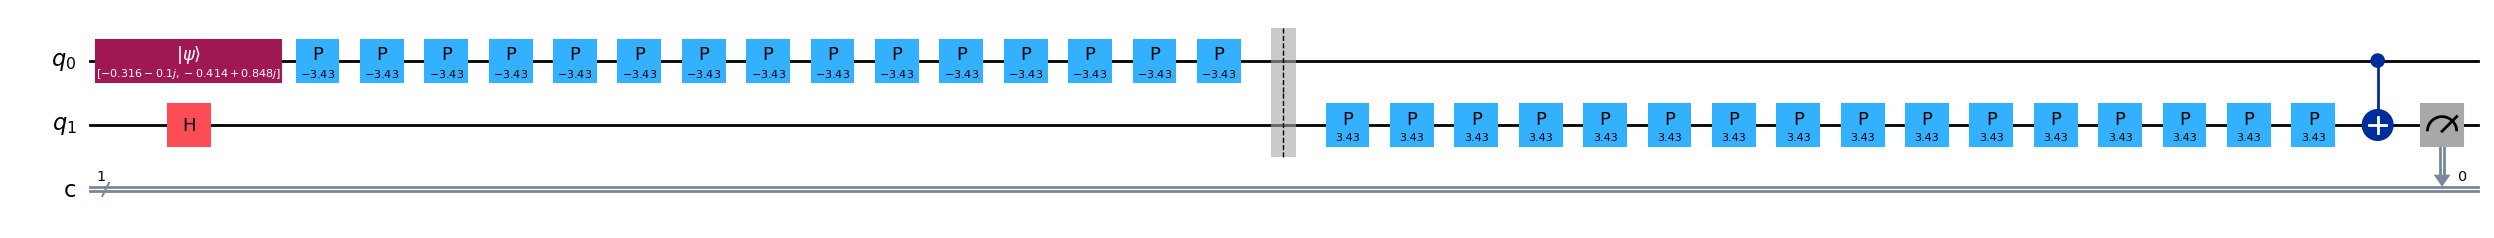

[{'1': 1}, {'1': 1}, {'1': 1}, {'1': 1}, {'1': 1}]


In [38]:
## MEASUREMENT SIMULATION
# with dynamic creation of circuits

# create initial circuit
register_number = 1
qc = vmc_circuit(NUMBER_OF_QUBITS, alpha, beta, register_number)

shots = 1 # you have only one measurement and based on its success you are either expanding circuit or not
list_of_results = []
while register_number <= MAX_REGISTERS:    
    result = qasm_simulation(qc)
    counts = result.get_counts()
    list_of_results.append(counts)

    # Clear the previous output and display the updated circuit
    clear_output(wait=True)
    display(qc.draw(output='mpl', fold=-1))  # Use Matplotlib for a nice circuit diagram
    # Pause for 1 second to simulate real-time update
    time.sleep(1)

    # if the result of measurement is |0>, we can end the loop, because U_{\varphi} is successfully applied on initial state \psi
    if "0" in counts:
        break

    # create new circuit that simulates the unsuccessful result of previous measurement (i.e. |1>)
    register_number += 1
    qc = vmc_circuit(NUMBER_OF_QUBITS, alpha, beta, register_number)
    
# print list of results for you circuits
print(list_of_results)

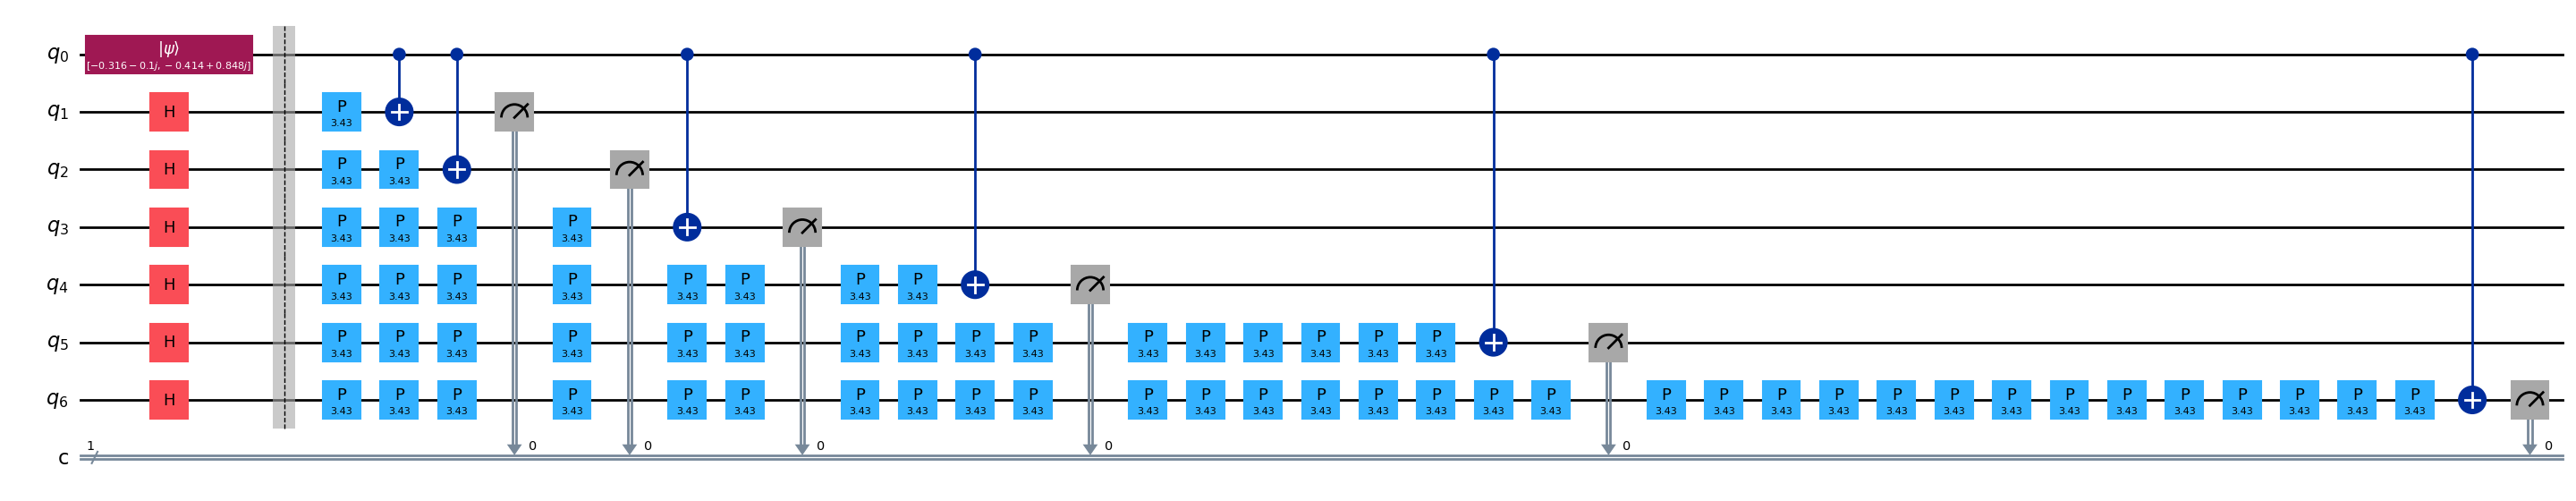

In [39]:
# draw the entire circuit in one piece
qc_resulting = vmc_circuit_static(register_number, alpha, beta)
qc_resulting.draw(output='mpl', fold=-1)

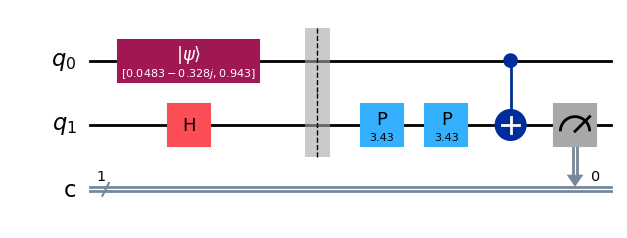

(-0.3160533948186194-0.10019143071965723j)  (-0.41389830520236953+0.8477972173725153j)
measuring: |1>
measuring: |0>
None
[Statevector([0.04827883-0.32802016j, 0.94343623+0.j        ],
            dims=(2,)), Statevector([-0.14137003-0.29990429j,  0.94343623+0.j        ],
            dims=(2,))]


In [9]:
## STATEVECTOR SIMULATION
# with recycling previous state

def prepare_state(num_of_phase_gates):
    qc = QuantumCircuit(1)
    qc.initialize(random_initial_state, 0)
    for i in range(num_of_phase_gates):
        qc.p(phase, 0).inverse()
    return statevector_simulation(qc).get_statevector()

# create initial circuit
register_number = 1
qc = vmc_circuit(NUMBER_OF_QUBITS, alpha, beta, register_number)

list_of_partial_states = []
list_of_partial_vectors = []
list_of_measured_states = []
while register_number <= MAX_REGISTERS:
    result = statevector_simulation(qc)
    statevector = result.get_statevector()
    partial_state = partial_trace(statevector, [1]).to_statevector()
    measured_state = partial_trace(statevector, [0]).to_statevector()
    list_of_partial_states.append(partial_state)
    list_of_measured_states.append(measured_state)

    partial_vector = partial_trace(DensityMatrix(statevector), [1]) # state after measuring |1><1| in Hilbert space 0
    # extract statevector because this is always pure state (you are only using unitaries)
    partial_vector = Statevector(np.sqrt(np.diag(partial_vector.data)))
    list_of_partial_vectors.append(partial_vector)
    
    # Clear the previous output and display the updated circuit
    clear_output(wait=True)
    display(qc.draw(output='mpl', fold=-1))  # Use Matplotlib for a nice circuit diagram
    # Pause for 1 second to simulate real-time update
    time.sleep(1)

    # if your measurement is successful, then you end here
    if abs(state_fidelity(measured_state, zerozero) - 1) < 0.01:
        break
    else:
        register_number += 1
        # recycle state, alpha is the first probbability amplitude and beta is the second one
        qc = vmc_circuit_recycled_state(NUMBER_OF_QUBITS, partial_state.data[0], partial_state.data[1], register_number) 

print(str(alpha) + "  " + str(beta))
print(write_measured_state(list_of_measured_states))
# print(list_of_partial_vectors)
print(list_of_partial_states)

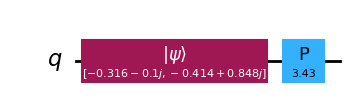

In [10]:
# CHECK FIDELITY
# in case of measuring |0>, we should get U_{\varphi}|\psi> = what remains in space 0 after measurement
# in case of measuring |1>, we should get U_{-N*\varphi}|\psi> = what remains in space 1 after measurement (N = 2**num_of_registers - 1)

# prepare transformed state U_{\varphi}|\psi>
qc_uphi = QuantumCircuit(1)
create_random_state_static(alpha, beta, qc_uphi)
qc_uphi.p(phase, 0)
qc_uphi.draw(output='mpl')

In [11]:
# calculate fidelity for successful measurement
uphi_initial_vector = Statevector.from_instruction(qc_uphi)
print(uphi_initial_vector.data)
uphi_initial_state = DensityMatrix.from_instruction(qc_uphi)
for measurement in range(len(list_of_measured_states)):
    if abs(state_fidelity(list_of_measured_states[measurement], zerozero) - 1) < 0.01: # if measurement is |0><0|
        print(uphi_initial_vector.equiv(list_of_partial_vectors[measurement]))
        print("Fidelity between initially transformed state and state after measuring |0><0|: " + 
              str(state_fidelity(uphi_initial_vector, list_of_partial_states[measurement])))

[-0.31605339-0.10019143j  0.64134122-0.69192006j]
False
Fidelity between initially transformed state and state after measuring |0><0|: 1.0000000000000004


In [12]:
# prepare list of states U_{-N\varphi}|\psi>
list_of_inversely_transformed_initial_state = []
list_of_inversely_transformed_initial_vectors = []
for register in range(MAX_REGISTERS + 1): # you need one additional circuit because you are applying zero gate in your first circuit
    num_of_inversed_phase_gates = 2**register - 1
    qc_uphi_inversed = QuantumCircuit(1)
    create_random_state_static(alpha, beta, qc_uphi_inversed)
    for i in range(num_of_inversed_phase_gates):
        qc_uphi_inversed.p(phase, 0).inverse()

    # #draw circuits
    # # Clear the previous output and display the updated circuit
    # clear_output(wait=True)
    # display(qc_uphi_inversed.draw(output='mpl', fold=-1))  # Use Matplotlib for a nice circuit diagram
    # # Pause for 1 second to simulate real-time update
    # time.sleep(1)

    # save states
    uphi_inversed_initial_state = Statevector.from_instruction(qc_uphi_inversed)
    list_of_inversely_transformed_initial_state.append(uphi_inversed_initial_state)
    list_of_inversely_transformed_initial_vectors.append(Statevector.from_instruction(qc_uphi_inversed))

In [13]:
# calculate fidelity for failed measurement
for measurement in range(len(list_of_measured_states)):
    if abs(state_fidelity(list_of_measured_states[measurement], oneone) - 1) < 0.01: # if measurement is |0><0|
        # you have to use the following circuit, because in the first circuit you are not applying any gate on initial state
        # only in the second circuit you are applying one inversed phase gate and so on so it is all shifted by one circuit
        print(list_of_inversely_transformed_initial_vectors[measurement + 1].equiv(list_of_partial_vectors[measurement]))
        print("Fidelity between initially inversely transformed state and state after measuring |1><1|: " + 
              str(state_fidelity(list_of_inversely_transformed_initial_state[measurement + 1], list_of_partial_states[measurement])))

False
Fidelity between initially inversely transformed state and state after measuring |1><1|: 1.0000000000000009


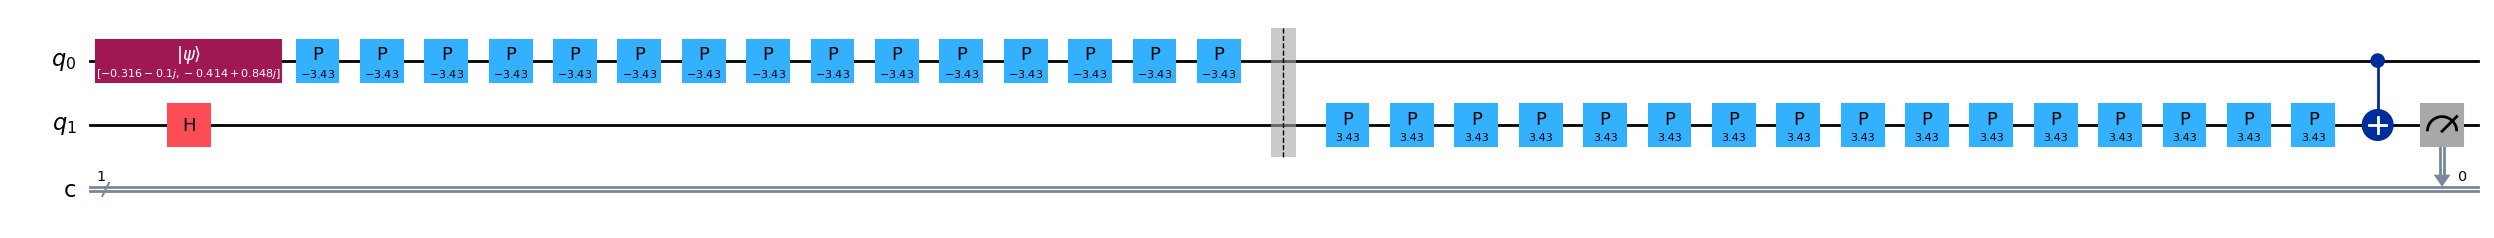

measuring: |0>
measuring: |1>
measuring: |0>
measuring: |0>
measuring: |0>
None


In [14]:
## STATEVECTOR SIMULATION
# with dynamic creation of circuits
# here I am creating inversely transformed initial states with the help of inversed phase gates applied on initial state in register 0

# create initial circuit
register_number = 1
qc = vmc_circuit(NUMBER_OF_QUBITS, alpha, beta, register_number)

list_of_partial_states = []
list_of_full_states = []
list_of_measured_states = []
while register_number <= MAX_REGISTERS:    
    result = statevector_simulation(qc)
    statevector = result.get_statevector()
    partial_state = partial_trace(DensityMatrix(statevector), [1])
    measured_state = partial_trace(DensityMatrix(statevector), [0])
    list_of_partial_states.append(partial_state)
    list_of_full_states.append(result.get_statevector())
    list_of_measured_states.append(measured_state)

    # Clear the previous output and display the updated circuit
    clear_output(wait=True)
    display(qc.draw(output='mpl', fold=-1))  # Use Matplotlib for a nice circuit diagram
    # Pause for 1 second to simulate real-time update
    time.sleep(1)
    
    # create new circuit that simulates the unsuccessful result of previous measurement (i.e. |1>)
    register_number += 1
    qc = vmc_circuit(NUMBER_OF_QUBITS, alpha, beta, register_number)

print(write_measured_state(list_of_measured_states))

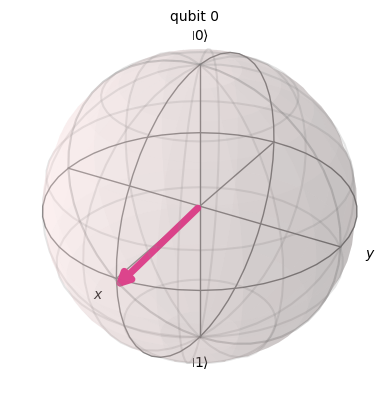

In [15]:
plot_bloch_multivector(random_initial_state)

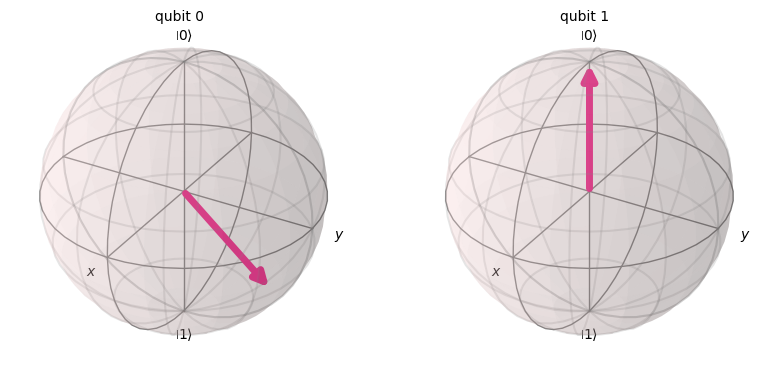

In [16]:
plot_bloch_multivector(list_of_full_states[0])

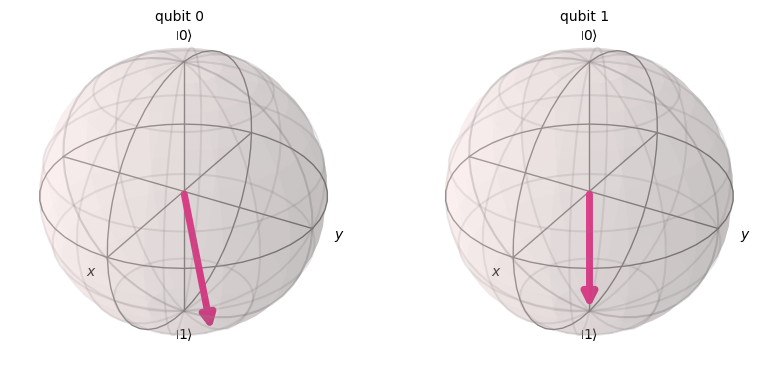

In [17]:
plot_bloch_multivector(list_of_full_states[1])

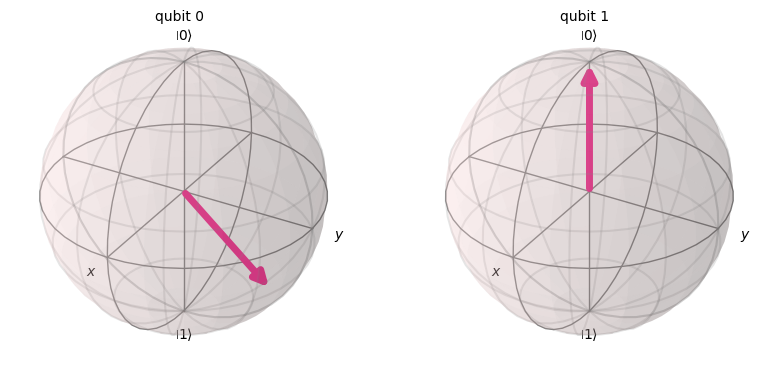

In [18]:
plot_bloch_multivector(list_of_full_states[2])

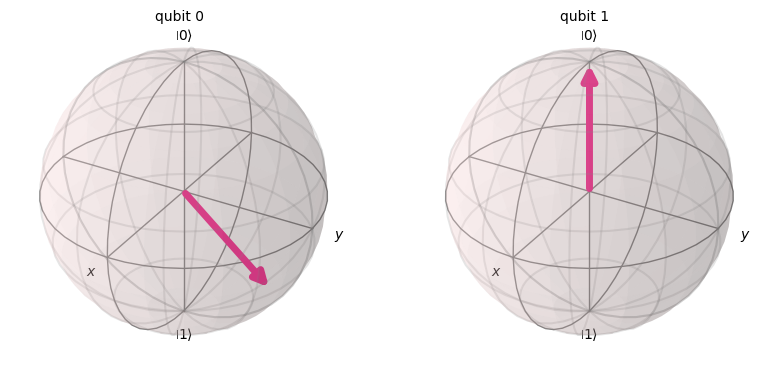

In [19]:
plot_bloch_multivector(list_of_full_states[3])

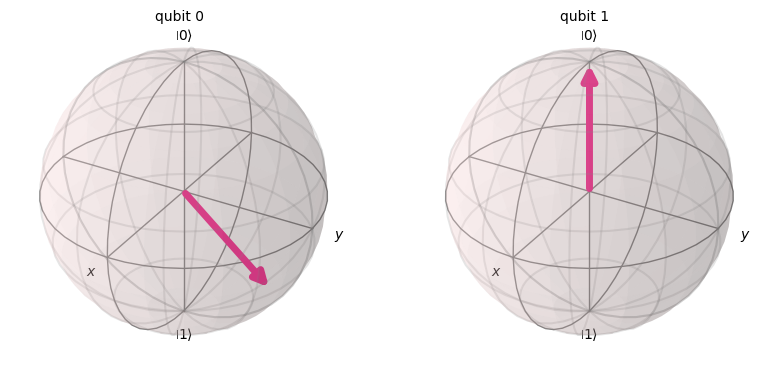

In [20]:
plot_bloch_multivector(list_of_full_states[4])

In [22]:
## RUN ON HARDWARE

# preparation
backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.backend(backend_name)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

# sampler
sampler = Sampler(backend)

# prepare first circuit
register_number = 1 # in the beginning you start with only one register (or the first one)
qc = vmc_circuit(NUMBER_OF_QUBITS, alpha, beta, register_number)

shots = 1 # you have only one measurement and based on its success you are either expanding circuit or not
list_of_jobs = []
list_of_results = []
list_of_qcs = []
list_of_transpiled_qcs = []
# ibm_brisbane supports for_loop
for register_number in range(1, MAX_REGISTERS + 1):
    # need to transpile every time
    transpiled_qc = pm.run(qc)
    list_of_transpiled_qcs.append(transpiled_qc)
    list_of_qcs.append(qc)

    # run job
    job = sampler.run([transpiled_qc], shots=shots)
    job_id = job.job_id()
    list_of_jobs.append(job_id)
    
    job = service.job(job_id)
    result = job.result()[0]
    data = result.data['c']
    counts = data.get_counts() # c is the name of classical register of qc
    list_of_results.append(counts)

    # if the result of measurement is |0>, we can end the loop, because U_{\varphi} is successfully applied on initial state \psi
    if "0" in counts:
        break

    # create new circuit that simulates the unsuccessful result of previous measurement (i.e. |1>)
    qc = vmc_circuit(NUMBER_OF_QUBITS, alpha, beta, register_number)

print("List of job ids: ", list_of_jobs)
print("List of results: ", list_of_results)
print("List of qcs: ", list_of_qcs)
print("List of transpiled qcs: " + str(list_of_transpiled_qcs))

List of job ids:  ['czb90ktqadq0008cdgmg']
List of results:  [{'0': 1}]
List of qcs:  [<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x0000021D98F9BD40>]
List of transpiled qcs: [<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x0000021D98F994F0>]


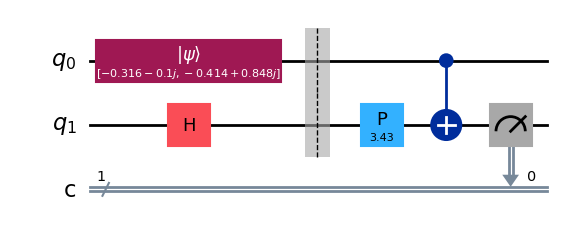

In [23]:
# draw all circuits from hardware
for qc in list_of_qcs:
    # Clear the previous output and display the updated circuit
    clear_output(wait=True)
    display(qc.draw(output='mpl', fold=-1))  # Use Matplotlib for a nice circuit diagram
    # Pause for 1 second to simulate real-time update
    time.sleep(1)

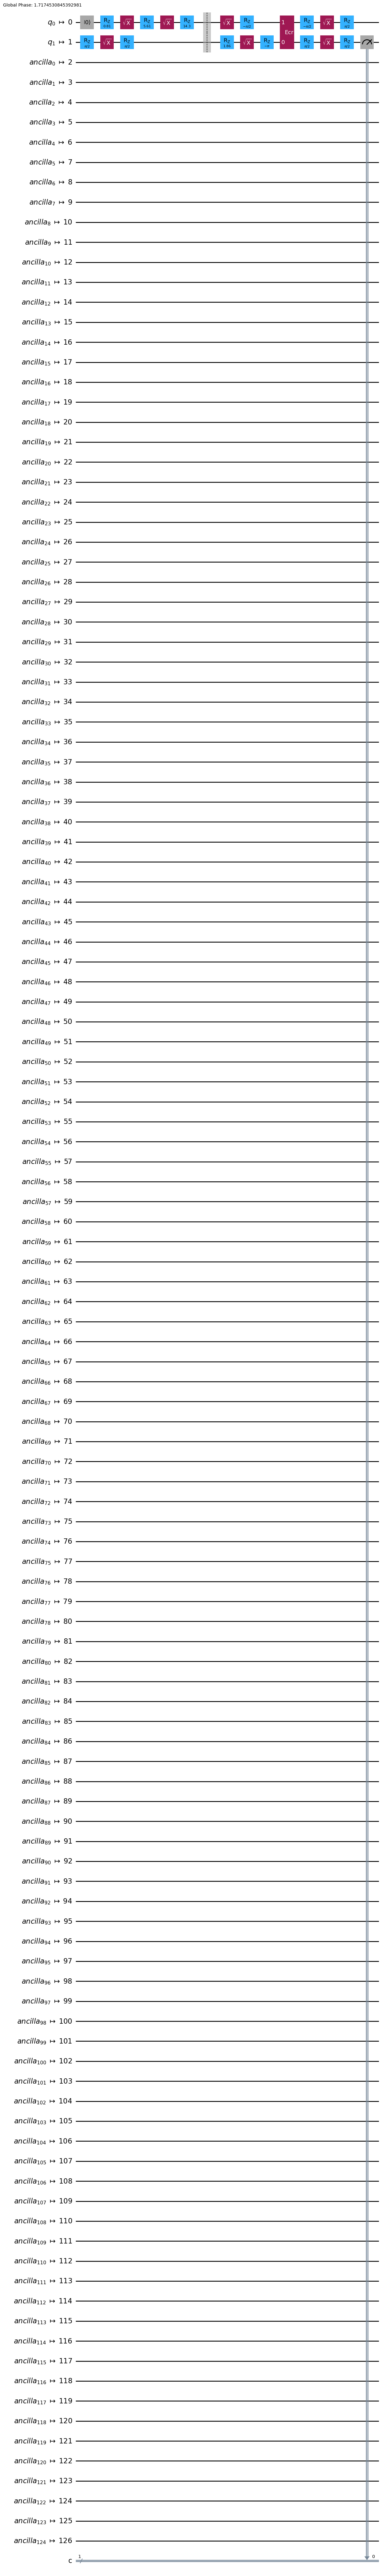

In [24]:
# draw all transpiled circuits from hardware
for tqc in list_of_transpiled_qcs:
    # Clear the previous output and display the updated circuit
    clear_output(wait=True)
    display(tqc.draw(output='mpl', fold=-1))  # Use Matplotlib for a nice circuit diagram
    # Pause for 1 second to simulate real-time update
    time.sleep(1)

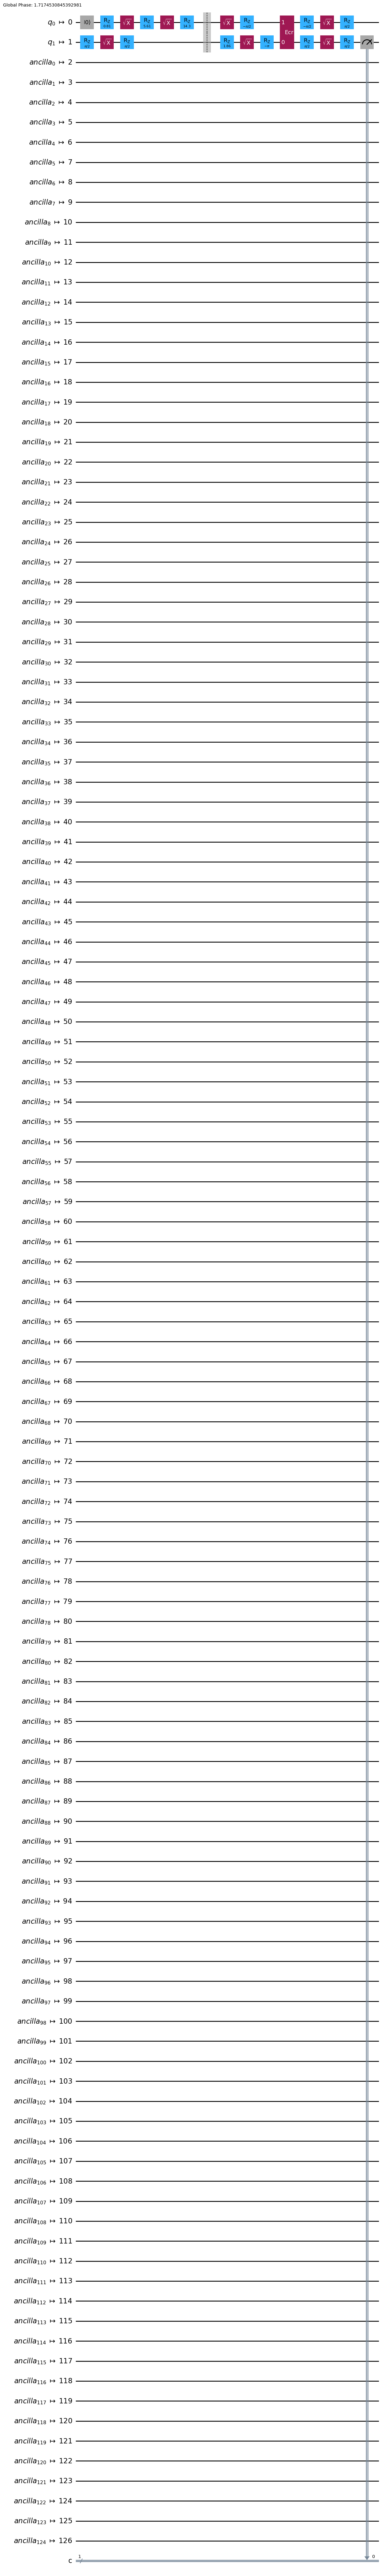

In [25]:
list_of_transpiled_qcs[0].draw(output='mpl', fold=-1)

In [26]:
list_of_transpiled_qcs[1].draw(output='mpl', fold=-1)

IndexError: list index out of range

In [27]:
list_of_transpiled_qcs[2].draw(output='mpl', fold=-1)

IndexError: list index out of range

In [28]:
list_of_transpiled_qcs[3].draw(output='mpl', fold=-1)

IndexError: list index out of range